### Bistable wilson and cowan like model

from : https://elifesciences.org/articles/22425#fig5

In [57]:
# for fast array manipulation
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for numerical ODE integration
from scipy.integrate import odeint
# for nonlinear equations
from scipy.optimize import fsolve
# to display plots in-line
%matplotlib inline
plt.style.use('ggplot')

In [58]:
def sigmoid(x, a, thr):
    return 1 / (1 + np.exp(-a * (x - thr)))

def threshold_linear(x,thr,gain):
    thresholded = x-thr
    if thresholded > 0:
        return gain*thresholded
    else:
        return 0 
    
vthreshold_linear = np.vectorize(threshold_linear)

In [163]:
# Time constant of neural pop in seconds
tau_e = 0.010
tau_i = 0.002
tau_a = 0.5
# Synapse strength
j_ee = 5
j_ei = 1
j_ie = 10
j_ii = 0.5
# Adaptation parameter
beta = 6
tau_a = 0.5
# threshold and gains
g_e = 1
g_i = 4
thr_i = 25
thr_e = 3 # to play with
# Input currents
I_e = 6
# I_e-thr_e = 3 which is equivalent to taking I_e = 0 and thr_e = -3 as in the paper



In [164]:
# this function returns the right hand side of the Wilson-Cowan equation
# (both, in a 2-vector)
def rate_model(y, t):
    E = y[0]
    I = y[1]
    A = y[2]
    y1 = (-E + vthreshold_linear(j_ee*E-j_ei*I-A+I_e,thr_e, g_e))/tau_e
    y2 = (-I + vthreshold_linear(j_ie*E-j_ii*I,thr_i,g_i))/tau_i
    y3 = (-A + beta*E)/tau_a
    return [y1, y2,y3]


In [165]:
# minimum and maximum E and I values we want displayed in the graph
minval = -.1
maxval = 20
resolution = 50
# State variables
x1 = np.linspace(minval, maxval, resolution)
x2 = np.linspace(minval, maxval, resolution)
x3 = np.linspace(minval, maxval, resolution)
# Create a grid for evaluation of the vector field
x1, x2, x3 = np.meshgrid(x1, x2, x3)
# Evaluate the slopes
X1, X2, X3 = rate_model([x1, x2, x3], 0)
# Compute the magnitude vector
M = np.hypot(X1, X2)
# Normalize the slopes vectors (for the field plot)
#X1, X2 = X1/M, X2/M

In [166]:
X1.shape

(50, 50, 50)

In [167]:
fixed_p = []
y1 = x1.ravel()
y2 = x2.ravel()
y3 = x3.ravel()
for i in range(resolution**2):
    # find a zero
    sol, infodict, ier, mesg = fsolve(rate_model,
                                      [y1[i], y2[i],y3[i]],
                                      args=(0),
                                      full_output=1)
    if ier == 1: # I exclude the cases where fsolve didn't converge
        fixed_p.append(sol)

fixed_p = np.array(fixed_p).T


In [168]:
# simulation duration and step size
time = np.linspace(0, 20, 2000)

# starting point, hopefully inside the basin of attraction of our attractor
E0, I0, A0 = 0, 0, 0 # try changing this

# find the solution with scint.odeint
odesol = odeint(rate_model, [E0, I0, A0], time)
# separate the two solutions
exc_timeseries, inh_timeseries, a_timeseries = odesol.T


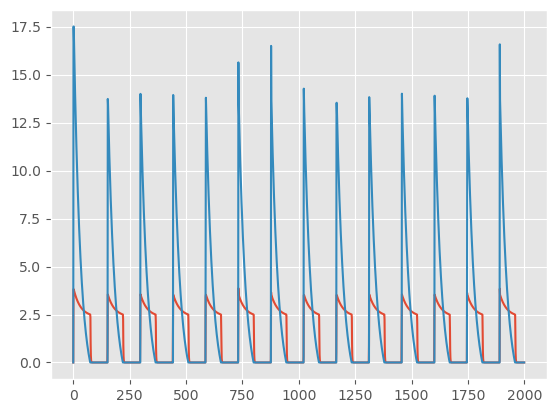

In [169]:
plt.plot(exc_timeseries);
plt.plot(inh_timeseries);

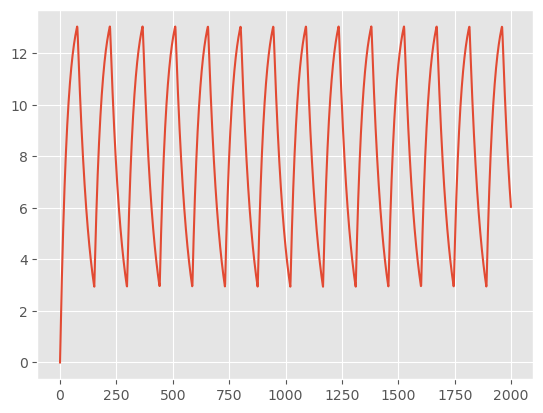

In [170]:
plt.plot(a_timeseries)

In [171]:
# # plotting the vector field in the state space (E, I)
# plt.figure(figsize=(10, 10))
# #plt.quiver(x2[:,:,49], x1[:,:,49], X2[:,:,49], X1[:,:,49], pivot='mid', alpha=.5)
# plt.xlim([minval, maxval])
# plt.ylim([minval, maxval])
# plt.xlabel(r'$I$', fontsize=16) # yes, you can use Latex code!
# plt.ylabel(r'$E$', fontsize=16)
# plt.grid()

# # plot the solution in the state space
# plt.plot(inh_timeseries, exc_timeseries, '.-');

# # plot the fixed points we identified
# plt.scatter(fixed_p[1], fixed_p[0], marker='o', c='k', s=50,
#             label="Stationary points")

# # plot the starting point
# plt.scatter(I0, E0, marker='*', c='r', s=300, label="Starting point")
# plt.legend(loc="upper left")

# # plot the solution in time
# plt.figure(figsize=(10.3,3))
# plt.ylabel(r'$E, I$')
# plt.xlabel(r'$t$')
# plt.plot(time, exc_timeseries, '.-', label="excitatory");
# plt.plot(time, inh_timeseries, '.-', label="inhibitory");
# plt.legend();